# Topic Modeling Articles using Non-Matrix Factorization

# Problem Statements: - 

For a financial company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers. 

 

These customer complaints are unstructured text data; so, traditionally, companies need to allocate the task of evaluating and assigning each ticket to the relevant department to multiple support employees. This becomes tedious as the company grows and has a large customer base.

We need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.


# Topic Modeling using Non-Negative Matrix Factorization

Here we will be using NMF(Non-Negative Matrix Factorization) with the help of this technique, which is an approach under topic modelling, we will detect patterns and recurring words present in each ticket. This can be then used to understand the important features for each cluster of categories. By segregating the clusters, we will be able to identify the topics of the customer complaints. 

# What is NMF(Non-Negative Matrix Factorization) ?

Non-Negative Matrix Factorization is a statistical method that helps us to reduce the dimension of the input corpora or corpora. Internally, it uses the factor analysis method to give comparatively less weightage to the words that are having less coherence.
Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

### Importing the Libraries

In [ ]:
!pip3 install -U gensim

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
nlp = spacy.load("en_core_web_sm")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
import en_core_web_sm

from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings("ignore")
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

### Library to connect with GDrive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Loading the Complaints Json Dataset

In [4]:
## Loading the JSON data containg complaints data
## The below will return the JSON object as a dictionay
file = open('/content/gdrive/MyDrive/ML_Projects/complaints-2021-05-14_08_16.json')
data = json.load(file)
complaints_data = pd.json_normalize(data)

In [5]:
complaints_data.head()

_index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00            CA  ...  Closed with explanation   
1  2019-05-01T12:00:00-05:00            GA  ...  Closed with explanation   
2  2019-04-02T12:00:00-05:00            TX  ...  Closed with explanation   
3  2017-09-13T12:00:00-05:00            MI  ...  Closed with explanation   
4  2019-04-05T12:00:00-05:00            NY  ...  Closed with explanation   

        _source.company _source.submitted_via _source.date_sent_to_company  \
0  JPMORGAN CHASE & CO.                   Web    2019-04-13T12:00:00-05:00   
1  JPMORGAN CHASE & CO.                   Web    2019-05-01T12:00:00-05:00   
2  JPMORGAN CHASE & CO.                   Web    2019-04-02T12:00:00-05:00   
3  JPMORGAN CHASE & CO.                   Web    2017-09-14T12:00:00-05:00   
4  JPMORGAN CHASE & CO.              Referral    2019-04-05T12:00:00-05:00   

  _source.company_public_response                         _source.sub_product  \
0                            None                            Credit card debt   
1                            None                            Credit card debt   
2                            None  General-purpose credit card or charge card   
3                            None                  Conventional home mortgage   
4                            None  General-purpose credit card or charge card   

  _source.timely                    _source.complaint_what_happened  \
0            Yes                                                      
1            Yes  Good morning my name is XXXX XXXX and I apprec...   
2            Yes  I upgraded my XXXX XXXX card in XX/XX/2018 and...   
3            Yes                                                      
4            Yes                                                      

                                  _source.sub_issue  \
0                                 Debt is not yours   
1  Didn't receive enough information to verify debt   
2             Problem with rewards from credit card   
3                                              None   
4                         Charged too much interest   

  _source.consumer_consent_provided  
0              Consent not provided  
1                  Consent provided  
2                  Consent provided  
3              Consent not provided  
4                               N/A  

[5 rows x 22 columns]

### Features in the given Complaint Dataset

In [6]:
## Listing all the columns in the dataset
list(complaints_data.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [7]:
complaints_data.columns = ['index','type','id','score','tags','zip_code',
                          'complaint_id','issue','date_received','state',
                          'consumer_disputed','product','company_response',
                          'company','submitted_via','date_sent_to_company',
                          'company_public_response','sub_product','timely',
                          'complaint_what_happened','sub_issue',
                          'consumer_consent_provided']

In [8]:
complaints_data.head(3)

index       type       id  score           tags zip_code  \
0  complaint-public-v2  complaint  3211475    0.0           None    90301   
1  complaint-public-v2  complaint  3229299    0.0  Servicemember    319XX   
2  complaint-public-v2  complaint  3199379    0.0           None    77069   

  complaint_id                               issue              date_received  \
0      3211475   Attempts to collect debt not owed  2019-04-13T12:00:00-05:00   
1      3229299     Written notification about debt  2019-05-01T12:00:00-05:00   
2      3199379  Other features, terms, or problems  2019-04-02T12:00:00-05:00   

  state  ...         company_response               company submitted_via  \
0    CA  ...  Closed with explanation  JPMORGAN CHASE & CO.           Web   
1    GA  ...  Closed with explanation  JPMORGAN CHASE & CO.           Web   
2    TX  ...  Closed with explanation  JPMORGAN CHASE & CO.           Web   

        date_sent_to_company company_public_response  \
0  2019-04-13T12:00:00-05:00                    None   
1  2019-05-01T12:00:00-05:00                    None   
2  2019-04-02T12:00:00-05:00                    None   

                                  sub_product timely  \
0                            Credit card debt    Yes   
1                            Credit card debt    Yes   
2  General-purpose credit card or charge card    Yes   

                             complaint_what_happened  \
0                                                      
1  Good morning my name is XXXX XXXX and I apprec...   
2  I upgraded my XXXX XXXX card in XX/XX/2018 and...   

                                          sub_issue consumer_consent_provided  
0                                 Debt is not yours      Consent not provided  
1  Didn't receive enough information to verify debt          Consent provided  
2             Problem with rewards from credit card          Consent provided  

[3 rows x 22 columns]

In [9]:
complaints_data.shape

(78313, 22)

### Replacing the blank cells with Nan

In [10]:
## Replacing blank cells in the "Complaints_what_happned" with nan
complaints_data[complaints_data['complaint_what_happened'] == ''] = np.nan

In [11]:
## Removing all rows where complaints column is nan
complaints_data = complaints_data.dropna(subset = ['complaint_what_happened'])

In [12]:
complaints_data.shape

(21072, 22)

# 1. Data Pre-Processing for prepare the text for topic modeling

*   Make the Text lower-case
*   Remove text in Square brackets
*   Remove Punctuations
*   Remove Numbers
*   Lemmatize the Text
*   Use the POS tag to get the relevant words from the text.



In [13]:
pd.options.mode.chained_assignment = None
complaints_data['complaint_what_happened'] = complaints_data['complaint_what_happened'].astype(str)
def clean_text(text):
    '''
        1. Make text lowercase
        2. Remove text in square brackets
        3. Remove punctuations.
        4. Remove numbers.
    '''
    text = text.lower()
    text = re.sub(r'\[.*?\]','', text)
    text = re.sub(r'[%s]'%re.escape(string.punctuation),'',text)
    text = re.sub(r'\w*\d\w*','',text)
    return(text)

complaints_data_clean = pd.DataFrame(complaints_data['complaint_what_happened'].apply(lambda x: clean_text(x)))

In [14]:
complaints_data_clean.head()

complaint_what_happened
1   good morning my name is xxxx xxxx and i apprec...
2   i upgraded my xxxx xxxx card in  and was told ...
10  chase card was reported on  however fraudulent...
11  on  while trying to book a xxxx  xxxx  ticket ...
14  my grand son give me check for  i deposit it i...

In [15]:
## Function to lemmatize the texts
def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return(" ".join(sent))

In [16]:
complaints_data_clean['Complaints_lemmatize'] = complaints_data_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis = 1)

In [17]:
complaints_data_clean.head()

complaint_what_happened  \
1   good morning my name is xxxx xxxx and i apprec...   
2   i upgraded my xxxx xxxx card in  and was told ...   
10  chase card was reported on  however fraudulent...   
11  on  while trying to book a xxxx  xxxx  ticket ...   
14  my grand son give me check for  i deposit it i...   

                                 Complaints_lemmatize  
1   good morning my name be xxxx xxxx and I apprec...  
2   I upgrade my xxxx xxxx card in   and be tell b...  
10  chase card be report on   however fraudulent a...  
11  on   while try to book a xxxx   xxxx   ticket ...  
14  my grand son give I check for   I deposit it i...

### Using Custom Chunking 

In [18]:
def pos_tag(text):
    try:
        return(TextBlob(text).tags)
    except:
        return(None)
    

def get_adjectives(text):
    blob = TextBlob(text)
    return(' '.join([word for (word,tag) in blob.tags if tag == 'NN']))


In [19]:
nlp = en_core_web_sm.load()
complaints_data_clean["complaint_POS_removed"] =  complaints_data_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

In [20]:
## Cleaned Dataframe
complaints_data_clean

complaint_what_happened  \
1      good morning my name is xxxx xxxx and i apprec...   
2      i upgraded my xxxx xxxx card in  and was told ...   
10     chase card was reported on  however fraudulent...   
11     on  while trying to book a xxxx  xxxx  ticket ...   
14     my grand son give me check for  i deposit it i...   
...                                                  ...   
78303  after being a chase card customer for well ove...   
78309  on wednesday xxxxxxxx i called chas my xxxx xx...   
78310  i am not familiar with xxxx pay and did not un...   
78311  i have had flawless credit for  yrs ive had ch...   
78312  roughly  years ago i closed out my accounts wi...   

                                    Complaints_lemmatize  \
1      good morning my name be xxxx xxxx and I apprec...   
2      I upgrade my xxxx xxxx card in   and be tell b...   
10     chase card be report on   however fraudulent a...   
11     on   while try to book a xxxx   xxxx   ticket ...   
14     my grand son give I check for   I deposit it i...   
...                                                  ...   
78303  after be a chase card customer for well over a...   
78309  on wednesday xxxxxxxx I call chas my xxxx xxxx...   
78310  I be not familiar with xxxx pay and do not und...   
78311  I have have flawless credit for   yr I ve have...   
78312  roughly   year ago I close out my account with...   

                                   complaint_POS_removed  
1      good morning my name be xxxx xxxx and I apprec...  
2      I upgrade my xxxx xxxx card in   and be tell b...  
10     chase card be report on   however fraudulent a...  
11     on   while try to book a xxxx   xxxx   ticket ...  
14     my grand son give I check for   I deposit it i...  
...                                                  ...  
78303  after be a chase card customer for well over a...  
78309  on wednesday xxxxxxxx I call chas my xxxx xxxx...  
78310  I be not familiar with xxxx pay and do not und...  
78311  I have have flawless credit for   yr I ve have...  
78312  roughly   year ago I close out my account with...  

[21072 rows x 3 columns]

# 2. Exploratory Data Analysis of Cleaned Dataset

*   Visualise the data according to the 'Complaint' character length.
*   Using a word cloud find the top 40 words by frequency among all the  articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

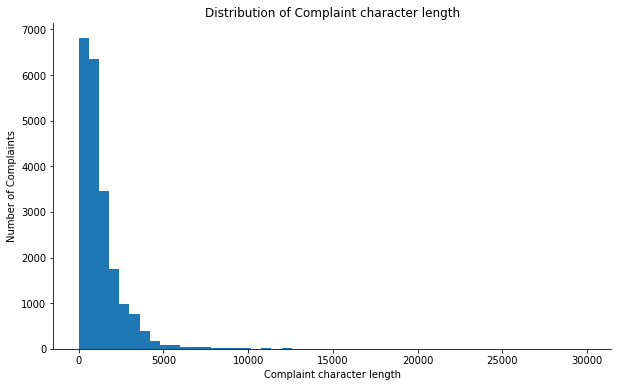

In [21]:
plt.figure(figsize = (10,6))
doc_lens = [len(d) for d in complaints_data_clean['complaint_POS_removed']]
plt.hist(doc_lens, bins = 50)
plt.title('Distribution of Complaint character length')
plt.ylabel('Number of Complaints')
plt.xlabel('Complaint character length')
sns.despine();

## Word-Cloud

Wordcloud as the name suggests is a cloud of words.To answer the above queries, we will have to deep dive into the concept of wordclouds. It is a visualization technique for text data wherein each word is picturized with its importance in the context or its frequency. 

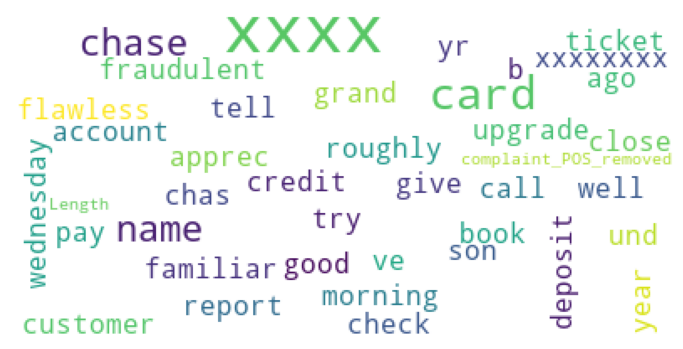

In [22]:
plt.rcParams['figure.figsize'] = (12.0,12.0)
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.subplot.bottom'] = 0.1
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    background_color = 'white',
    stopwords = stopwords,
    max_words = 40,
    max_font_size = 40,
    random_state = 42
).generate(str(complaints_data_clean['complaint_POS_removed']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [23]:
#Removing -PRON- from the text corpus
complaints_data_clean['Complaint_clean'] = complaints_data_clean['complaint_POS_removed'].str.replace('xxxx', '')
complaints_data_clean['Complaint_clean'] = complaints_data_clean['Complaint_clean'].str.replace('xxxxxxxx', '')

# Unigram Model:-
N-grams is also termed as a sequence of n words. The language model which is based on determining probability based on the count of the sequence of words can be called as N-gram language model. Based on the count of words, N-gram can be:

*   Unigram: Sequence of just 1 word
*   Bigram: Sequence of 2 words
*   Trigram: Sequence of 3 words

In natural language processing, an n-gram is a sequence of n words. For example, “statistics” is a unigram (n = 1), “machine learning” is a bigram (n = 2), “natural language processing” is a trigram (n = 3). For longer n-grams, people just use their lengths to identify them, such as 4-gram, 5-gram, and so on. In this part of the project, we will focus only on language models based on unigrams i.e. single words.

In [24]:
def get_top_n_words(corpus, n = None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x:x[1], reverse = True)
    return(words_freq[:n])
common_words = get_top_n_words(complaints_data_clean['Complaint_clean'].values.astype('U'),50)
complaints_data2 = pd.DataFrame(common_words, columns = ['unigram', 'count'])

fig = go.Figure([go.Bar(x = complaints_data2['unigram'], y = complaints_data2['count'])])
fig.update_layout(title = go.layout.Title(text = "Top 50 unigrams in the Complaints dataset after removing stop words and lemmatization"))
fig.show()

In [25]:
complaints_data2.head(10)

unigram  count
0    chase  80516
1  account  48679
2   credit  34138
3     card  30530
4     bank  28419
5  payment  21170
6     tell  19674
7   charge  18231
8  receive  17720
9     make  17356

## Bigram Model

In [26]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x:x[1], reverse = True)
    return(words_freq[:n])

common_words = get_top_n_bigram(complaints_data_clean['Complaint_clean'].values.astype('U'),30)
complaints_data3 = pd.DataFrame(common_words, columns = ['bigram','count'])
fig = go.Figure([go.Bar(x = complaints_data3['bigram'], y = complaints_data3['count'])])
fig.update_layout(title = go.layout.Title(text = "Top 30 bigrams in the Complaints data after removing stopwords and lemmatization"))
fig.show()

In [27]:
complaints_data3.head()

bigram  count
0        chase bank  12840
1       credit card  12815
2     credit report   3987
3  checking account   3232
4  customer service   3065

## Trigram Model

In [28]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x:x[1], reverse = True)
    return(words_freq[:n])

common_words = get_top_n_trigram(complaints_data_clean['Complaint_clean'].values.astype('U'),30)
complaints_data4 = pd.DataFrame(common_words, columns = ['trigram','count'])
fig = go.Figure([go.Bar(x = complaints_data4['trigram'], y = complaints_data4['count'])])
fig.update_layout(title = go.layout.Title(text = "Top 30 trigrams in the Complaints data after removing stopwords and lemmatization"))
fig.show()

In [29]:
complaints_data4.head()

trigram  count
0      jp morgan chase   2363
1    chase credit card   2273
2  credit card account    986
3  credit card company    968
4    credit card chase    816

# 3. Features Extraction

*   Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [116]:
tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

In [117]:
## Create a document term matrix using fit_transform
dtm = tfidf.fit_transform(complaints_data_clean['Complaint_clean'])

In [121]:
## Use Gensim's NMF to get the best num of topics via coherence score
texts = complaints_data_clean['Complaint_clean']
dataset = [d.split() for d in texts]

In [122]:
dataset

[['good',
  'morning',
  'my',
  'name',
  'be',
  'and',
  'I',
  'appreciate',
  'it',
  'if',
  'you',
  'could',
  'help',
  'I',
  'put',
  'a',
  'stop',
  'to',
  'chase',
  'bank',
  'cardmember',
  'service',
  'in',
  'I',
  'write',
  'to',
  'chase',
  'ask',
  'for',
  'debt',
  'verification',
  'and',
  'what',
  'they',
  'send',
  'I',
  'a',
  'statement',
  'which',
  'be',
  'not',
  'acceptable',
  'I',
  'be',
  'ask',
  'the',
  'bank',
  'to',
  'validate',
  'the',
  'debt',
  'instead',
  'I',
  'been',
  'receive',
  'mail',
  'every',
  'month',
  'from',
  'they',
  'attempt',
  'to',
  'collect',
  'a',
  'debt',
  'I',
  'have',
  'a',
  'right',
  'to',
  'know',
  'this',
  'information',
  'as',
  'a',
  'consumer',
  'chase',
  'account',
  'thank',
  'in',
  'advance',
  'for',
  'your',
  'help'],
 ['I',
  'upgrade',
  'my',
  'card',
  'in',
  'and',
  'be',
  'tell',
  'by',
  'the',
  'agent',
  'who',
  'do',
  'the',
  'upgrade',
  'my',
  'ann

In [123]:
# Use Gensim's NMF to get the best num of topics via coherence score
## Use Gensim's NMF to get the best num of topics via coherence score

texts = complaints_data_clean['Complaint_clean']
dataset = [x.split() for x in texts]

# Creating a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Creating the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_num = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_num:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=40
    )
    
    # Run the coherence model to get the score
    coherence_model = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(coherence_model.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_num, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

5


## Manual Topic Modeling

In [124]:
nmf_model = NMF(n_components = 5, random_state = 40)

In [125]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

11867

In [126]:
## Print the top word of a sample component
single_topic = nmf_model.components_[0]
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(tfidf.get_feature_names()[index])

open
tell
fund
close
deposit
money
chase
bank
check
account


In [127]:
## Print Top 15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'The Top 25 Words for Topic#{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

The Top 25 Words for Topic#0
['cash', 'ask', 'customer', 'claim', 'transaction', 'send', 'receive', 'hold', 'number', 'business', 'transfer', 'day', 'say', 'branch', 'checking', 'open', 'tell', 'fund', 'close', 'deposit', 'money', 'chase', 'bank', 'check', 'account']


The Top 25 Words for Topic#1
['year', 'authorize', 'use', 'bureaus', 'letter', 'identity', 'reporting', 'jpmcb', 'limit', 'application', 'information', 'debt', 'close', 'open', 'company', 'score', 'apply', 'remove', 'account', 'hard', 'chase', 'inquiry', 'report', 'card', 'credit']


The Top 25 Words for Topic#2
['state', 'debt', 'refinance', 'morgan', 'jp', 'pay', 'sale', 'house', 'tell', 'receive', 'bank', 'rate', 'foreclosure', 'time', 'document', 'request', 'year', 'send', 'letter', 'property', 'modification', 'home', 'chase', 'mortgage', 'loan']


The Top 25 Words for Topic#3
['credit', 'company', 'pay', 'time', 'cancel', 'contact', 'email', 'make', 'fraudulent', 'say', 'tell', 'use', 'service', 'fraud', 'receive', 

In [128]:
## Creating the best topic for each complaint
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis = 1)

array([2, 3, 1, ..., 3, 4, 4])

In [129]:
complaints_data_clean['Topic'] = topic_results.argmax(axis = 1)

In [130]:
complaints_data_clean.head()

complaint_what_happened  \
1   good morning my name is xxxx xxxx and i apprec...   
2   i upgraded my xxxx xxxx card in  and was told ...   
10  chase card was reported on  however fraudulent...   
11  on  while trying to book a xxxx  xxxx  ticket ...   
14  my grand son give me check for  i deposit it i...   

                                 Complaints_lemmatize  \
1   good morning my name be xxxx xxxx and I apprec...   
2   I upgrade my xxxx xxxx card in   and be tell b...   
10  chase card be report on   however fraudulent a...   
11  on   while try to book a xxxx   xxxx   ticket ...   
14  my grand son give I check for   I deposit it i...   

                                complaint_POS_removed  \
1   good morning my name be xxxx xxxx and I apprec...   
2   I upgrade my xxxx xxxx card in   and be tell b...   
10  chase card be report on   however fraudulent a...   
11  on   while try to book a xxxx   xxxx   ticket ...   
14  my grand son give I check for   I deposit it i...   

                                      Complaint_clean  Topic  
1   good morning my name be   and I appreciate it ...      2  
2   I upgrade my   card in   and be tell by the ag...      3  
10  chase card be report on   however fraudulent a...      1  
11  on   while try to book a       ticket I come a...      1  
14  my grand son give I check for   I deposit it i...      0

In [131]:
complaints_tm = complaints_data_clean.groupby('Topic').head(5)
complaints_tm.sort_values('Topic')

complaint_what_happened  \
27   i opened an account with chase bank on xxxx an...   
14   my grand son give me check for  i deposit it i...   
17   with out notice jp morgan chase restricted my ...   
24   mishandling of this account by chase auto and ...   
35   i opened the saving account for the  bonus i w...   
10   chase card was reported on  however fraudulent...   
11   on  while trying to book a xxxx  xxxx  ticket ...   
15                       can you please remove inquiry   
23   i have a chase credit card which is incorrectl...   
26   i have reached out to xxxx several times in at...   
73   i have wired through one of chase branches in ...   
57   i have been trying to do a loan modification w...   
43   chase sent me an email today with the innocuou...   
1    good morning my name is xxxx xxxx and i apprec...   
20   during the summer months i experience a declin...   
32   my chase amazon card was declined for a cateri...   
40   xxxx xxxx a sofa love seat table and chairs an...   
21   on xxxx  i made a  payment to an online retail...   
2    i upgraded my xxxx xxxx card in  and was told ...   
30   to whom it may concern chase bank charged wron...   
141  action taken by the company between the dates ...   
58   i made a purchase of  on xxxxxxxx i made payme...   
82   i recently called to ask chase bank why they r...   
115  multiple times with the latest being xxxxxxxx ...   
164  in xxxx of this year chase withdrew money from...   

                                  Complaints_lemmatize  \
27   I open an account with chase bank on xxxx and ...   
14   my grand son give I check for   I deposit it i...   
17   with out notice jp morgan chase restrict my ac...   
24    mishandle of this account by chase auto and xxxx   
35   I open the saving account for the   bonus I be...   
10   chase card be report on   however fraudulent a...   
11   on   while try to book a xxxx   xxxx   ticket ...   
15                       can you please remove inquiry   
23   I have a chase credit card which be incorrectl...   
26   I have reach out to xxxx several time in attem...   
73   I have wire through one of chase branch in xxx...   
57   I have be try to do a loan modification with c...   
43   chase send I an email today with the innocuous...   
1    good morning my name be xxxx xxxx and I apprec...   
20   during the summer month I experience a decline...   
32   my chase amazon card be decline for a catering...   
40   xxxx xxxx a sofa love seat table and chair and...   
21   on xxxx   I make a   payment to an online reta...   
2    I upgrade my xxxx xxxx card in   and be tell b...   
30   to whom it may concern chase bank charge wrong...   
141  action take by the company between the date of...   
58   I make a purchase of   on xxxxxxxx I make paym...   
82   I recently call to ask chase bank why they rep...   
115  multiple time with the late being xxxxxxxx cha...   
164  in xxxx of this year chase withdraw money from...   

                                 complaint_POS_removed  \
27   I open an account with chase bank on xxxx and ...   
14   my grand son give I check for   I deposit it i...   
17   with out notice jp morgan chase restrict my ac...   
24    mishandle of this account by chase auto and xxxx   
35   I open the saving account for the   bonus I be...   
10   chase card be report on   however fraudulent a...   
11   on   while try to book a xxxx   xxxx   ticket ...   
15                       can you please remove inquiry   
23   I have a chase credit card which be incorrectl...   
26   I have reach out to xxxx several time in attem...   
73   I have wire through one of chase branch in xxx...   
57   I have be try to do a loan modification with c...   
43   chase send I an email today with the innocuous...   
1    good morning my name be xxxx xxxx and I apprec...   
20   during the summer month I experience a decline...   
32   my chase amazon card be decline for a catering...   
40   xxxx xxxx a sofa love 

In [132]:
complaints_data_clean['Topic'].unique()

array([2, 3, 1, 0, 4])

In [133]:
## Create the dictionary of Topic names and Topics
Topic_names = {0: "Credit card/Prepaid card",
               1: "Bank Account services",
               2:"Mortgages/loans",
               3:"Dispute/Fraud Reporting",
               4:"Others"}

In [134]:
complaints_data_clean['Topic'] = complaints_data_clean['Topic'].map(Topic_names)

In [135]:
complaints_data_clean

complaint_what_happened  \
1      good morning my name is xxxx xxxx and i apprec...   
2      i upgraded my xxxx xxxx card in  and was told ...   
10     chase card was reported on  however fraudulent...   
11     on  while trying to book a xxxx  xxxx  ticket ...   
14     my grand son give me check for  i deposit it i...   
...                                                  ...   
78303  after being a chase card customer for well ove...   
78309  on wednesday xxxxxxxx i called chas my xxxx xx...   
78310  i am not familiar with xxxx pay and did not un...   
78311  i have had flawless credit for  yrs ive had ch...   
78312  roughly  years ago i closed out my accounts wi...   

                                    Complaints_lemmatize  \
1      good morning my name be xxxx xxxx and I apprec...   
2      I upgrade my xxxx xxxx card in   and be tell b...   
10     chase card be report on   however fraudulent a...   
11     on   while try to book a xxxx   xxxx   ticket ...   
14     my grand son give I check for   I deposit it i...   
...                                                  ...   
78303  after be a chase card customer for well over a...   
78309  on wednesday xxxxxxxx I call chas my xxxx xxxx...   
78310  I be not familiar with xxxx pay and do not und...   
78311  I have have flawless credit for   yr I ve have...   
78312  roughly   year ago I close out my account with...   

                                   complaint_POS_removed  \
1      good morning my name be xxxx xxxx and I apprec...   
2      I upgrade my xxxx xxxx card in   and be tell b...   
10     chase card be report on   however fraudulent a...   
11     on   while try to book a xxxx   xxxx   ticket ...   
14     my grand son give I check for   I deposit it i...   
...                                                  ...   
78303  after be a chase card customer for well over a...   
78309  on wednesday xxxxxxxx I call chas my xxxx xxxx...   
78310  I be not familiar with xxxx pay and do not und...   
78311  I have have flawless credit for   yr I ve have...   
78312  roughly   year ago I close out my account with...   

                                         Complaint_clean  \
1      good morning my name be   and I appreciate it ...   
2      I upgrade my   card in   and be tell by the ag...   
10     chase card be report on   however fraudulent a...   
11     on   while try to book a       ticket I come a...   
14     my grand son give I check for   I deposit it i...   
...                                                  ...   
78303  after be a chase card customer for well over a...   
78309  on wednesday  I call chas my   visa credit car...   
78310  I be not familiar with  pay and do not underst...   
78311  I have have flawless credit for   yr I ve have...   
78312  roughly   year ago I close out my account with...   

                          Topic  
1               Mortgages/loans  
2       Dispute/Fraud Reporting  
10        Bank Account services  
11        Bank Account services  
14     Credit card/Prepaid card  
...                         ...  
78303   Dispute/Fraud Reporting  
78309   Dispute/Fraud Reporting  
78310   Dispute/Fraud Reporting  
78311                    Others  
78312                    Others  

[21072 rows x 5 columns]

## Supervised model to predict any new complaints to the relevant Topics

In [150]:
Topic_names = {"Credit card/Prepaid card":0,"Bank Account services":1,"Mortgages/loans":2,"Dispute/Fraud Reporting":3,"Others":4}
complaints_data_clean['Topic'] = complaints_data_clean['Topic'].map(Topic_names)

In [151]:
complaints_data_clean['Topic'].head()

1     2
2     3
10    1
11    1
14    0
Name: Topic, dtype: int64

In [152]:
training_data = complaints_data_clean[['complaint_what_happened','Topic']]
training_data.head()

complaint_what_happened  Topic
1   good morning my name is xxxx xxxx and i apprec...      2
2   i upgraded my xxxx xxxx card in  and was told ...      3
10  chase card was reported on  however fraudulent...      1
11  on  while trying to book a xxxx  xxxx  ticket ...      1
14  my grand son give me check for  i deposit it i...      0

In [153]:
## Get vector count
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

## Save Word Vector
pickle.dump(count_vect.vocabulary_, open("/content/gdrive/MyDrive/ML_Projects/count_vector.pkl","wb"))

In [154]:
## Transform word Vector to TF-IDF
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

## Save TF-IDF
pickle.dump(tfidf_transformer, open("/content/gdrive/MyDrive/ML_Projects/tfidf.pkl","wb"))

In [155]:
training_data['Topic'].isnull().sum()
#training_data.shape

0

In [156]:
training_data['Topic'].unique()

array([2, 3, 1, 0, 4])

# 1. Multinomial Naive Bayes

In [157]:
x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, training_data['Topic'], test_size = 0.25, random_state = 42)
clf = MultinomialNB().fit(x_train, y_train)

## Save the model
pickle.dump(clf, open("/content/gdrive/MyDrive/ML_Projects/nb_model.pkl","wb"))

In [160]:
## Add target names here
target_names = ["Credit card/Prepaid card",
               "Bank Account services",
               "Mortgages/loans",
               "Dispute/Fraud Reporting",
               "Others"]

## The new document
docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]


## LOAD MODEL
loaded_vec = CountVectorizer(vocabulary = pickle.load(open("/content/gdrive/MyDrive/ML_Projects/count_vector.pkl","rb")))
loaded_tfidf = pickle.load(open("/content/gdrive/MyDrive/ML_Projects/tfidf.pkl","rb"))
loaded_model = pickle.load(open("/content/gdrive/MyDrive/ML_Projects/nb_model.pkl","rb"))

x_new_counts = loaded_vec.transform(docs_new)
x_new_tfidf = loaded_tfidf.transform(x_new_counts)
predicted = loaded_model.predict(x_new_tfidf)

print(target_names[predicted[0]])

Mortgages/loans


In [161]:
predicted = loaded_model.predict(x_test)
result_bayes = pd.DataFrame({'true_labels': y_test, 'predicted_labels':predicted})

for predicted_item, result in zip(predicted, y_test):
  print(target_names[predicted_item], " - ", target_names[result])
     

Streaming output truncated to the last 5000 lines.
Dispute/Fraud Reporting  -  Credit card/Prepaid card
Mortgages/loans  -  Mortgages/loans
Credit card/Prepaid card  -  Credit card/Prepaid card
Dispute/Fraud Reporting  -  Others
Dispute/Fraud Reporting  -  Bank Account services
Bank Account services  -  Bank Account services
Dispute/Fraud Reporting  -  Dispute/Fraud Reporting
Credit card/Prepaid card  -  Credit card/Prepaid card
Credit card/Prepaid card  -  Credit card/Prepaid card
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Dispute/Fraud Reporting  -  Mortgages/loans
Mortgages/loans  -  Bank Account services
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgages/loans  -  Mortgages/loans
Dispute/Fraud Reporting  -  Dispute/Fraud Reporting
Credit card/Prepaid card  -  Credit card/Prepaid card
Dispute/Fraud Reporting  -  Dispute/Fraud Reporting
Dispute/Fraud Reporting  -  Dispute/Fraud Reporting
Credit card/P

# Evaluate Naive bayes Model

In [166]:
confusion_mat = confusion_matrix(y_test, predicted)
print(confusion_mat)


## Add target names
target_names = ["Credit card/Prepaid card",
               "Bank Account services",
               "Mortgages/loans",
               "Dispute/Fraud Reporting",
               "Others"]
print(classification_report(y_test, predicted, target_names = target_names))

[[1091   14    3  158    0]
 [  73  539   37  370    0]
 [  86   13  789  126    0]
 [  57    5    4 1336    0]
 [  64   37  110  349    7]]
                          precision    recall  f1-score   support

Credit card/Prepaid card       0.80      0.86      0.83      1266
   Bank Account services       0.89      0.53      0.66      1019
         Mortgages/loans       0.84      0.78      0.81      1014
 Dispute/Fraud Reporting       0.57      0.95      0.71      1402
                  Others       1.00      0.01      0.02       567

                accuracy                           0.71      5268
               macro avg       0.82      0.63      0.61      5268
            weighted avg       0.78      0.71      0.67      5268



# 2. Logistic Regression

In [164]:
x_train,x_test,y_train,y_test = train_test_split(x_train_tfidf,training_data['Topic'], test_size = 0.25, random_state = 42)
logistic_model = LogisticRegression(random_state = 0).fit(x_train, y_train)

## Save Model
pickle.dump(logistic_model, open("/content/gdrive/MyDrive/ML_Projects/logreg_model.pkl","wb"))

In [168]:
## Target names
target_names = ["Credit card/Prepaid card",
               "Bank Account services",
               "Mortgages/loans",
               "Dispute/Fraud Reporting",
               "Others"]

## New document test dataset
docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]

## Load model
loaded_vec = CountVectorizer(vocabulary = pickle.load(open("/content/gdrive/MyDrive/ML_Projects/count_vector.pkl","rb")))
loaded_tfidf = pickle.load(open("/content/gdrive/MyDrive/ML_Projects/tfidf.pkl","rb"))
loaded_model = pickle.load(open("/content/gdrive/MyDrive/ML_Projects/logreg_model.pkl","rb"))

x_new_counts = loaded_vec.transform(docs_new)
x_new_tfidf = loaded_tfidf.transform(x_new_counts)
predicted = loaded_model.predict(x_new_tfidf)

print(target_names[predicted[0]])

Mortgages/loans


In [170]:
predicted = loaded_model.predict(x_test)
result_logistic = pd.DataFrame({'true_labels':y_test,'predicted_labels':predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Credit card/Prepaid card  -  Credit card/Prepaid card
Mortgages/loans  -  Mortgages/loans
Credit card/Prepaid card  -  Credit card/Prepaid card
Others  -  Others
Dispute/Fraud Reporting  -  Bank Account services
Bank Account services  -  Bank Account services
Dispute/Fraud Reporting  -  Dispute/Fraud Reporting
Credit card/Prepaid card  -  Credit card/Prepaid card
Credit card/Prepaid card  -  Credit card/Prepaid card
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Mortgages/loans  -  Mortgages/loans
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgages/loans  -  Mortgages/loans
Dispute/Fraud Reporting  -  Dispute/Fraud Reporting
Credit card/Prepaid card  -  Credit card/Prepaid card
Dispute/Fraud Reporting  -  Dispute/Fraud Reporting
Dispute/Fraud Reporting  -  Dispute/Fraud Reporting
Credit card/Prepaid card  -  Cr

# Evaluate Logitic Model Results

In [171]:
confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)

## ADD target names
target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

print(classification_report(y_test, predicted, target_names=target_names))

[[1216    8   10   30    2]
 [  20  937   18   40    4]
 [  21   16  943   28    6]
 [  35   20   16 1326    5]
 [  19   11   22   20  495]]
                             precision    recall  f1-score   support

      Bank Account services       0.93      0.96      0.94      1266
Credit card or prepaid card       0.94      0.92      0.93      1019
              Mortgage/Loan       0.93      0.93      0.93      1014
            Theft Reporting       0.92      0.95      0.93      1402
                     Others       0.97      0.87      0.92       567

                   accuracy                           0.93      5268
                  macro avg       0.94      0.93      0.93      5268
               weighted avg       0.93      0.93      0.93      5268



# 3. Decision Tree

In [173]:
x_train, x_test,y_train,y_test = train_test_split(x_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
decison_tree_model = DecisionTreeClassifier(random_state = 0).fit(x_train,y_train)

## Save Model
pickle.dump(decison_tree_model, open("/content/gdrive/MyDrive/ML_Projects/DT_model.pkl","wb"))

In [174]:
## Add target names ---here
target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("/content/gdrive/MyDrive/ML_Projects/count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("/content/gdrive/MyDrive/ML_Projects/tfidf.pkl","rb"))
loaded_model = pickle.load(open("/content/gdrive/MyDrive/ML_Projects/DT_model.pkl","rb"))

x_new_counts = loaded_vec.transform(docs_new)
x_new_tfidf = loaded_tfidf.transform(x_new_counts)
predicted = loaded_model.predict(x_new_tfidf)

print(target_names[predicted[0]])

Mortgage/Loan


In [175]:
predicted = loaded_model.predict(x_test)
result_decision_tree = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Others  -  Others
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft Reporting  -  Theft Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft Reporting  -  Theft Reporting
Bank Account services  -  Bank Account services
Theft Reporting  -  Theft Reporting
Theft Reporting  -  Theft Reporting
Bank Account services  -  Bank Account services
Others  -  Others
Bank Account services

# Evaluate Decision Tree Model

In [176]:
confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)

## Add target names here ---
target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

print(classification_report(y_test, predicted, target_names=target_names))

[[ 984   47   47  157   31]
 [  49  780   54  103   33]
 [  65   35  794   68   52]
 [ 139  116   73 1020   54]
 [  41   40   48   51  387]]
                             precision    recall  f1-score   support

      Bank Account services       0.77      0.78      0.77      1266
Credit card or prepaid card       0.77      0.77      0.77      1019
              Mortgage/Loan       0.78      0.78      0.78      1014
            Theft Reporting       0.73      0.73      0.73      1402
                     Others       0.69      0.68      0.69       567

                   accuracy                           0.75      5268
                  macro avg       0.75      0.75      0.75      5268
               weighted avg       0.75      0.75      0.75      5268



# 4. Random Forest

In [177]:
# Random Forest
x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
random_forest = RandomForestClassifier(max_depth=10, random_state=0)
random_forest.fit(x_train, y_train)

#SAVE MODEL
pickle.dump(random_forest, open("/content/gdrive/MyDrive/ML_Projects/RF_model.pkl", "wb"))

In [178]:
## Add target names here ---
target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary = pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("/content/gdrive/MyDrive/ML_Projects/tfidf.pkl","rb"))
loaded_model = pickle.load(open("/content/gdrive/MyDrive/ML_Projects/RF_model.pkl","rb"))

x_new_counts = loaded_vec.transform(docs_new)
x_new_tfidf = loaded_tfidf.transform(x_new_counts)
predicted = loaded_model.predict(x_new_tfidf)

print(target_names[predicted[0]])

Mortgage/Loan


In [180]:
predicted = loaded_model.predict(x_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Theft Reporting  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Others  -  Others
Theft Reporting  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft Reporting  -  Theft Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Theft Reporting  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft Reporting  -  Theft Reporting
Bank Account services  -  Bank Account services
Theft Reporting  -  Theft Reporting
Theft Reporting  -  Theft Reporting
Bank Account services  -  Bank Account services
Theft Reporting  -  Others
Bank Account services  -  Ba

# Evaluate Random Forest Model

In [181]:
confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

print(classification_report(y_test, predicted, target_names=target_names))

[[1112   16    2  136    0]
 [  57  669   19  274    0]
 [  55   22  783  154    0]
 [  75   10    2 1315    0]
 [  92   87  104  274   10]]
                             precision    recall  f1-score   support

      Bank Account services       0.80      0.88      0.84      1266
Credit card or prepaid card       0.83      0.66      0.73      1019
              Mortgage/Loan       0.86      0.77      0.81      1014
            Theft Reporting       0.61      0.94      0.74      1402
                     Others       1.00      0.02      0.03       567

                   accuracy                           0.74      5268
                  macro avg       0.82      0.65      0.63      5268
               weighted avg       0.79      0.74      0.70      5268

